# Imports

In [1]:
# This is what we're working with

import warnings
warnings.filterwarnings("ignore")

import requests
import nba_api
from nba_api.stats.endpoints import teamdashboardbygeneralsplits, leaguedashteamstats
from nba_api.stats.endpoints import leaguegamelog, scoreboard, leaguestandings

from datetime import date, timedelta
import time


# import shap 
# shap.initjs()
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# from sklearn import model_selection
# from sklearn.utils import class_weight
# from sklearn.metrics import confusion_matrix

In [ ]:
# Compile a dictionary of all 30 NBA teams and their Team ID
teams = {"Atlanta Hawks": 1610612737,
        "Boston Celtics": 1610612738,
        "Brooklyn Nets": 1610612751,
        "Charlotte Bobcats": 1610612766,
        "Charlotte Hornets": 1610612766,
        "Chicago Bulls": 1610612741,
        "Cleveland Cavaliers": 1610612739,
        "Dallas Mavericks": 1610612742,
        "Denver Nuggets": 1610612743,
        "Detroit Pistons": 1610612765,
        "Golden State Warriors": 1610612744,
        "Houston Rockets": 1610612745,
        "Indiana Pacers": 1610612754,
        "LA Clippers": 1610612746,
        "Los Angeles Clippers": 1610612746,
        "Los Angeles Lakers": 1610612747,
        "Memphis Grizzlies": 1610612763,
        "Miami Heat": 1610612748,
        "Milwaukee Bucks": 1610612749,
        "Minnesota Timberwolves": 1610612750,
        "New Jersey Nets": 1610612751,
        "New Orleans Hornets": 1610612740,
        "New Orleans Pelicans": 1610612740,
        "New York Knicks": 1610612752,
        "Oklahoma City Thunder": 1610612760,
        "Orlando Magic": 1610612753,
        "Philadelphia 76ers": 1610612755,
        "Phoenix Suns": 1610612756,
        "Portland Trail Blazers": 1610612757,
        "Sacramento Kings": 1610612758,
        "San Antonio Spurs": 1610612759,
        "Toronto Raptors": 1610612761,
        "Utah Jazz": 1610612762,
        "Washington Wizards": 1610612764,
    }

# Advanced Stats
Stats like field goal percentage, rebounds, and turnovers are easily digested by NBA viewers. Some people don't like stats. They would rather apply the eye-test and see for themselves whether a team is any good. Others realize that stats can tell a story about the game but only if they know how to use them. Advanced stats play this role and help us dissect the drama unfolding on the court. Therefore, traditional and advanced stats will be cast in our models.

### True Shooting Percentage
There are 3 ways that an NBA player can score: 3-pointers, 2-pointers and free throws. True shooting percentage ('TS_PCT') looks at all three. 3-pointers are a little tricky to factor into the equation. The max true shooting percentage  is 150% and can only be reached if a player hits every one of their shots and they're all from behind the arch. Because this stat accounts for all shots, it's easily the best measure of shooting ability. 

For example, if a player goes 1-for-1 and their only shot is from the hash-mark, the formula will read and simplify as follows (please just trust and accept that the .44 multiplier is the best way of estimating the total number of possessions a player is involved in):

$$\frac{points} {2 *fga + .44 * fta}$$

$$\frac{3}  {2 * 1 + .44 * 0} = \frac{3}{2} = {1.5}$$

In [ ]:
# Compile a dictionary of stats and their source 
available_stats = {'W_PCT': 'Base',
                   'FG_PCT': 'Base',
                   'FG3_PCT': 'Base',
                   'FT_PCT': 'Base',
                   'REB': 'Base',
                   'AST': 'Base',
                   'TOV': 'Base',
                   'STL': 'Base',
                   'BLK': 'Base',
                   'PLUS_MINUS': 'Base',
                   'OFF_RATING': 'Advanced',
                   'DEF_RATING': 'Advanced',
                   'TS_PCT': 'Advanced'}

### Offensive and defensive rating
Basketball stresses efficiency. Minimizing points allowed and maximizing points scored on each possession is more important than overall totals. Totals are shaped by variables like pace — or the number of possessions a team gets in a game — which differs depending on coaching (i.e. the Golden State Warriors averaged 3 fewer possessions per game than the Los Angeles Lakers last season).

This is where tempo-free stats offensive and defensive rating come into play. Defensive rating shows how many points a player allows per 100 possessions. This statistic functions differently than a plus/minus system, where all points scored while a player is on the court count against them. Only the shots that are scored as a result of their defensive lapses are counted against them. 

Offensive rating is simpler to calculate. It's just the amount of points produced by a player per 100 possessions. Again, the reason offensive and defensive ratings are useful is because they're tempo-free stats. Offensive and defensive rating eliminate factors like pace of play and minutes played per game. Below is the formula for offensive rating:

$$ \frac{100*pp} {fga + .44 * fta + to}$$

# Webscraping

In [ ]:
from nba_api.stats.endpoints import teamdashboardbygeneralsplits, leaguedashteamstats


def get_team_stats_dict(team, start_date, end_date, season='2021-22'):
    """
    Returns the stats for the selected team in a dataframe, default year is 2021-22
    :param start_data: Day of games scheduled in form 'mm/dd/yyyy'
    :param end_data: Day of games scheduled in form 'mm/dd/yyyy'
    :param season: Day of games scheduled in form 'yyyy-yy'
    :return: A dictionary of game matchups {home_team:[away_team]}
    """

    time.sleep(1)

    
    # Load teamdashboardbygeneralsplits to access 'Per100Possessions' team stats
    general_team_info = teamdashboardbygeneralsplits.TeamDashboardByGeneralSplits(team_id=teams[team],
                                                                                  per_mode_detailed='Per100Possessions',
                                                                                  season=season,
                                                                                  date_from_nullable=start_date,
                                                                                  date_to_nullable=end_date,
                                                                                  timeout=120)
    # Move into general_team_info dictionary
    general_team_dict = general_team_info.get_normalized_dict()
    general_team_dashboard = general_team_dict['OverallTeamDashboard'][0]


    # Select stat columns to webscrape from general_team_info dictionary
    win_percentage = general_team_dashboard['W_PCT']
    fg_percentage = general_team_dashboard['FG_PCT']
    fg3_percentage = general_team_dashboard['FG3_PCT']
    ft_percentage = general_team_dashboard['FT_PCT']
    rebounds = general_team_dashboard['REB']
    assists = general_team_dashboard['AST']
    turnovers = general_team_dashboard['TOV']
    steals = general_team_dashboard['STL']
    blocks = general_team_dashboard['BLK']
    plus_minus = general_team_dashboard['PLUS_MINUS']

    
    # Load teamdashboardbygeneralsplits to access Advanced team stats
    advanced_team_info = teamdashboardbygeneralsplits.TeamDashboardByGeneralSplits(team_id=teams[team],
                                                                                   measure_type_detailed_defense='Advanced',
                                                                                   season=season,
                                                                                   date_from_nullable=start_date,
                                                                                   date_to_nullable=end_date,
                                                                                   timeout=120)
                                                                            
    # Move into advanced_team_info dictionary
    advanced_team_dict = advanced_team_info.get_normalized_dict()
    advanced_team_dashboard = advanced_team_dict['OverallTeamDashboard'][0]

    # Select stat columns to webscrape from advanced_team_info dictionary
    offensive_rating = advanced_team_dashboard['OFF_RATING']
    defensive_rating = advanced_team_dashboard['DEF_RATING']
    true_shooting_percentage = advanced_team_dashboard['TS_PCT']

    # Create a dictionary containing both the traditional and advanced stats 
    # and match them with the correspondiing variables outline above
    all_stats_dict = {'W_PCT': win_percentage, 
                      'FG_PCT': fg_percentage, 
                      'FG3_PCT': fg3_percentage, 
                      'FT_PCT': ft_percentage, 
                      'REB': rebounds, 
                      'AST': assists, 
                      'TOV': turnovers, 
                      'STL': steals, 
                      'BLK': blocks, 
                      'PLUS_MINUS': plus_minus, 
                      'OFF_RATING': offensive_rating, 
                      'DEF_RATING': defensive_rating, 
                      'TS_PCT': true_shooting_percentage}

    return all_stats_dict

In [ ]:
# Call get_team_stats_dict() function and pass in a team, start_date, end_date, season
get_team_stats_dict('Golden State Warriors', '10/19/2021', '04/10/2022', '2021-22')

In [ ]:
from nba_api.stats.endpoints import leaguegamelog, scoreboard, leaguestandings

def get_match_results(date, season):
    """
    Returns the matchup and result of the game

    :param date: Day of games scheduled in form 'mm/dd/yyyy'
    :param season: Season in form of 'yyyy-yy'
    :return: [{Golden State Warriors: Boston Celtics}], ['W']
    """

    # Load leaguegamelog to access 'Regular Season' game logs
    game_log = leaguegamelog.LeagueGameLog(season=season, 
                                           league_id='00', 
                                           date_from_nullable=date,
                                           date_to_nullable=date, 
                                           season_type_all_star='Regular Season', 
                                           timeout=120)
    # Move into game_log dictionary
    game_log_dict = game_log.get_normalized_dict()
    list_of_teams = game_log_dict['LeagueGameLog']

    daily_match = {}
    win_loss = []
    score = []
    game_id = []

    for i in range(0, len(list_of_teams), 2):

        if '@' in list_of_teams[i]['MATCHUP']:

            # Select Away team
            away_team = list_of_teams[i]['TEAM_NAME']
            
            # Select Home team
            home_team = list_of_teams[i + 1]['TEAM_NAME']

            # Append Home team win or loss
            win_loss.append(list_of_teams[i + 1]['WL'])

            # Append Game ID
            game_id.append(list_of_teams[i + 1]['GAME_ID'])

            # Append Home team score
            score.append(list_of_teams[i + 1]['PTS'])
            
            # Append Away team score
            score.append(list_of_teams[i]['PTS'])

        else:
            # Select Away team
            away_team = list_of_teams[i + 1]['TEAM_NAME']
            
            # Select Home team
            home_team = list_of_teams[i]['TEAM_NAME']

            # Append Away team win or loss
            win_loss.append(list_of_teams[i]['WL'])

            # Append Game ID
            game_id.append(list_of_teams[i]['GAME_ID'])

            # Append Away team score
            score.append(list_of_teams[i]['PTS'])
            
            # Append Home team score
            score.append(list_of_teams[i + 1]['PTS'])

        daily_match.update({home_team: away_team})

    match_results = [daily_match, win_loss, score, game_id]

    return match_results

In [ ]:
def get_daily_matches(date):
    """
    This function creates a dictionary of daily game matchups and their results.

    :param date: Day of games scheduled in form 'mm/dd/yyyy'
    :return: A dictionary of game matchups {home_team:away_team}
    """

    # Load scoreboard to access each team's 'TEAM_ID' 
    daily_match = scoreboard.Scoreboard(league_id='00', game_date=date, timeout=120)
    
    # Move into daily_match dictionary
    daily_match_dict = daily_match.get_normalized_dict()
    games = daily_match_dict['GameHeader']

    match = {}

    # Loop through games
    for game in games:

        # Select 'HOME_TEAM_ID'
        home_team_id = game['HOME_TEAM_ID']

        # Assign home_team variable with the team name that goes along with the home_team_id
        for team, team_id in teams.items():
            if team_id == home_team_id:
                home_team = team

        # Select 'VISITOR_TEAM_ID'
        away_team_id = game['VISITOR_TEAM_ID']

        # Assign away_team variable with the team name that goes along with the away_team_id
        for team, team_id in teams.items():
            if team_id == away_team_id:
                away_team = team

        # Update the match dictionary with a dictionary of Home and Away team names
        match.update({home_team: away_team})

    return match

In [ ]:
# Run both get_daily_matches() and get_match_results() functions
def main():
    print(f"""
    'get_daily_matches()' returns a dictionary of the games on a specified date\n{get_daily_matches('12/25/22')}\n
    """)
    
    print(f"""
    'get_match_results()' returns the matchup plus the result\n{get_match_results('10/19/2021', '2021-22')}
    """)
    
# 1. Return a dictionary of the games on a specified date
# 2. Return the matchup plus the game results
main()

In [ ]:
from datetime import date, timedelta
import requests

def to_dataframe(daily_games, start_date, end_date, season):
    """
    This function creates a DataFrame of daily game matchups and their results.

    :param daily_games: get_match_results()
    :param start_data: Day of games scheduled in form 'mm/dd/yyyy'
    :param end_data: Day of games scheduled in form 'mm/dd/yyyy'
    :param season: Day of games scheduled in form 'yyyy-yy'
    :return: A dictionary of game matchups {home_team:away_team}
    """
    full_dataframe = []
    game_number = 0  # Counter to match with the corresponding game
    daily_results = daily_games[1]  # Win or loss for each game
    score = daily_games[2] # Score for the game
    game_id = daily_games[3] # Game ID for the game

    # loops through games to access home and away teams
    for home_team, away_team in daily_games[0].items():  # loops through matchups
        
        # Pull home team stats
        home_team_stats = get_team_stats_dict(home_team, start_date, end_date, season)
        
        # Pull away team stats
        away_team_stats = get_team_stats_dict(away_team, start_date, end_date, season)

        current_game = [home_team, away_team]
        
        current_game.append(game_id[game_number])

        current_game.append(score.pop(0))

        # Append home team stats
        for stat, stat_type in available_stats.items():
            current_game.append(home_team_stats[stat])
        
        current_game.append(score.pop(0))

        # Append away team stats
        for stat, stat_type in available_stats.items():
            current_game.append(away_team_stats[stat])

        # Assign 1 for a W and 0 for an L
        if daily_results[game_number] == 'W':
            result = 1
        else:
            result = 0

        current_game.append(result)
        game_number += 1

        print(current_game)

        # Appned full game stats to full_dataframe list
        full_dataframe.append(current_game)

    return full_dataframe

In [ ]:
# Define function  to plug in date ranges for game data you'd like to webscrape
def date_range(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)
        
        
# Define function  to plug in date ranges for game data you'd like to webscrape
def training_set(start_year, start_month, start_day, end_year, end_month, end_day, season, season_start):
    start_date = date(start_year, start_month, start_day)
    end_date = date(end_year, end_month, end_day)

    total_games = []

    for single_date in date_range(start_date, end_date):
        current_date = single_date.strftime('%m/%d/%Y')
        print(current_date)

        previous_day = single_date - timedelta(days=1)
        previous_day_formatted = previous_day.strftime('%m/%d/%Y')

        current_day_games = get_match_results(current_date, season)
        current_day_games_with_stats = to_dataframe(current_day_games, season_start, previous_day_formatted, season)

        for game in current_day_games_with_stats:
            game.append(current_date)
            total_games.append(game)

    print(total_games)
    return total_games

In [ ]:
# Create DataFrame shell with column names to fill with webescraped game data
def make_dataframe(game_list):
    games = pd.DataFrame(game_list,
                         columns=['Home', 
                                  'Away', 
                                  'Game_ID', 
                                  'H_Score', 
                                  'H_W_PCT', 
                                  'H_FG_PCT', 
                                  'H_FG3_PCT', 
                                  'H_FT_PCT',
                                  'H_REB', 
                                  'H_AST', 
                                  'H_TOV', 
                                  'H_STL',
                                  'H_BLK', 
                                  'H_PLUS_MINUS', 
                                  'H_OFF_RATING', 
                                  'H_DEF_RATING', 
                                  'H_TS_PCT', 
                                  'A_Score',
                                  'A_W_PCT', 
                                  'A_FG_PCT', 
                                  'A_FG3_PCT',
                                  'A_FT_PCT', 
                                  'A_REB', 
                                  'A_AST', 
                                  'A_TOV', 
                                  'A_STL',
                                  'A_BLK', 
                                  'A_PLUS_MINUS', 
                                  'A_OFF_RATING', 
                                  'A_DEF_RATING', 
                                  'A_TS_PCT', 
                                  'Result',
                                  'Date'])

    print(games)
    return games

In [ ]:
# Function extracts NBA game data for a specied time period
def main():
    
    attempts = 10

    for i in range(attempts):
        try:
            # Plug in date ranges for game data you'd like to webscrape
            all_games = training_set(start_year=2016, 
                                     start_month=3, 
                                     start_day=20, 
                                     end_year=2016, 
                                     end_month=4, 
                                     end_day=14,
                                     season='2015-16', 
                                     season_start='10/27/2015')
            
            # Aligns data with correct columns in new DataFrame
            df = make_dataframe(all_games)

            print(df)
            
            # Convert game data to a csv file
            df.to_csv(r'C:\Users\alvaro\OneDrive\Documents\School\Flatiron\Projects\NBA_Prediction_Model\data\nba_df_2015_v7.csv', 
                      index=False)
        
        except requests.exceptions.ReadTimeout:
            
            if i < attempts - 1:
                continue
            
            else:
                raise
        
        break

        
# Initialize webscraping of game data 
if __name__ == '__main__':
    main()

# Seasons
After webscrapping for a few days we've amassed 7 seasons of data. From the 2015-16 season to the most recent 2021-22 season. Some of the webscrapping had to be done in parts because the NBA API would error out. Doing it like this was slower but we can avoid errors and the annoyance of losing the data we've collected during the webscrape. Slow and steady wins the race.
## 2015 - 16

In [ ]:
# # Read csv, convert date time, assign new column 'Season' with the correct year
# df_2015 = pd.read_csv('./data/nba_df_2015.csv')
# df_2015['Date'] = pd.to_datetime(df_2015['Date'])
# df_2015['Season'] = '2015-16'

# df_2015_2 = pd.read_csv('./data/nba_df_2015_v2.csv')
# df_2015_2['Date'] = pd.to_datetime(df_2015_2['Date'])
# df_2015_2['Season'] = '2015-16'

# df_2015_3 = pd.read_csv('./data/nba_df_2015_v3.csv')
# df_2015_3['Date'] = pd.to_datetime(df_2015_3['Date'])
# df_2015_3['Season'] = '2015-16'

# df_2015_4 = pd.read_csv('./data/nba_df_2015_v4.csv')
# df_2015_4['Date'] = pd.to_datetime(df_2015_4['Date'])
# df_2015_4['Season'] = '2015-16'

# df_2015_5 = pd.read_csv('./data/nba_df_2015_v5.csv')
# df_2015_5['Date'] = pd.to_datetime(df_2015_5['Date'])
# df_2015_5['Season'] = '2015-16'

# df_2015_6 = pd.read_csv('./data/nba_df_2015_v6.csv')
# df_2015_6['Date'] = pd.to_datetime(df_2015_6['Date'])
# df_2015_6['Season'] = '2015-16'

# df_2015_7 = pd.read_csv('./data/nba_df_2015_v7.csv')
# df_2015_7['Date'] = pd.to_datetime(df_2015_7['Date'])
# df_2015_7['Season'] = '2015-16'

# df_2015_playoffs = pd.read_csv('./data/nba_df_2015_playoffs.csv')
# df_2015_playoffs['Date'] = pd.to_datetime(df_2015_playoffs['Date'])
# df_2015_playoffs['Season'] = '2015-16'


# # print(len(df_2015), len(df_2015_2), len(df_2015_3), len(df_2015_4), len(df_2015_5), len(df_2015_6), len(df_2015_7), len(df_2015_playoffs))
# print(len(df_2015), len(df_2015_2), len(df_2015_3), len(df_2015_4), len(df_2015_5), len(df_2015_6), len(df_2015_7))

In [ ]:
# # Concat all DataFrames to make one for the season
# frames = [df_2015, df_2015_2, df_2015_3, df_2015_4, df_2015_5, df_2015_6, df_2015_7, df_2015_playoffs]
# frames = [df_2015, df_2015_2, df_2015_3, df_2015_4, df_2015_5, df_2015_6, df_2015_7]
# df_2015_final = pd.concat(frames)
# len(df_2015_final)

## 2016 - 17

In [ ]:
# Read csv, convert date time, assign new column 'Season' with the correct year
df_2016 = pd.read_csv('./data/nba_df_2016.csv')
df_2016['Date'] = pd.to_datetime(df_2016['Date'])
df_2016['Season'] = '2016-17'

df_2016_2 = pd.read_csv('./data/nba_df_2016_v2.csv')
df_2016_2['Date'] = pd.to_datetime(df_2016_2['Date'])
df_2016_2['Season'] = '2016-17'

df_2016_3 = pd.read_csv('./data/nba_df_2016_v3.csv')
df_2016_3['Date'] = pd.to_datetime(df_2016_3['Date'])
df_2016_3['Season'] = '2016-17'

df_2016_4 = pd.read_csv('./data/nba_df_2016_v4.csv')
df_2016_4['Date'] = pd.to_datetime(df_2016_4['Date'])
df_2016_4['Season'] = '2016-17'

df_2016_5 = pd.read_csv('./data/nba_df_2016_v5.csv')
df_2016_5['Date'] = pd.to_datetime(df_2016_5['Date'])
df_2016_5['Season'] = '2016-17'

df_2016_6 = pd.read_csv('./data/nba_df_2016_v6.csv')
df_2016_6['Date'] = pd.to_datetime(df_2016_6['Date'])
df_2016_6['Season'] = '2016-17'

df_2016_7 = pd.read_csv('./data/nba_df_2016_v7.csv')
df_2016_7['Date'] = pd.to_datetime(df_2016_7['Date'])
df_2016_7['Season'] = '2016-17'

df_2016_8 = pd.read_csv('./data/nba_df_2016_v8.csv')
df_2016_8['Date'] = pd.to_datetime(df_2016_8['Date'])
df_2016_8['Season'] = '2016-17'

# df_2016_playoffs = pd.read_csv('./data/nba_df_2016_playoffs.csv')
# df_2016_playoffs['Date'] = pd.to_datetime(df_2016_playoffs['Date'])
# df_2016_playoffs['Season'] = '2016-17'



# print(len(df_2016), len(df_2016_2), len(df_2016_3), len(df_2016_4), len(df_2016_5), len(df_2016_6), len(df_2016_7), len(df_2016_8), len(df_2016_playoffs))
print(len(df_2016), len(df_2016_2), len(df_2016_3), len(df_2016_4), len(df_2016_5), len(df_2016_6), len(df_2016_7), len(df_2016_8))

In [ ]:
# Concat all DataFrames to make one for the season
# frames = [df_2016, df_2016_2, df_2016_3, df_2016_4, df_2016_5, df_2016_6, df_2016_7, df_2016_8, df_2016_playoffs]
frames = [df_2016, df_2016_2, df_2016_3, df_2016_4, df_2016_5, df_2016_6, df_2016_7, df_2016_8]
df_2016_final = pd.concat(frames)
len(df_2016_final)

## 2017 - 18

In [ ]:
# Read csv, convert date time, assign new column 'Season' with the correct year
df_2017 = pd.read_csv('./data/nba_df_2017.csv')
df_2017['Date'] = pd.to_datetime(df_2017['Date'])
df_2017['Season'] = '2017-18'

df_2017_2 = pd.read_csv('./data/nba_df_2017_v2.csv')
df_2017_2['Date'] = pd.to_datetime(df_2017_2['Date'])
df_2017_2['Season'] = '2017-18'

df_2017_3 = pd.read_csv('./data/nba_df_2017_v3.csv')
df_2017_3['Date'] = pd.to_datetime(df_2017_3['Date'])
df_2017_3['Season'] = '2017-18'

# df_2017_playoffs = pd.read_csv('./data/nba_df_2017_playoffs.csv')
# df_2017_playoffs['Date'] = pd.to_datetime(df_2017_playoffs['Date'])
# df_2017_playoffs['Season'] = '2017-18'


# print(len(df_2017), len(df_2017_2), len(df_2017_3), len(df_2017_playoffs))
print(len(df_2017), len(df_2017_2), len(df_2017_3))

In [ ]:
# Concat all DataFrames to make one for the season
# frames = [df_2017, df_2017_2, df_2017_3, df_2017_playoffs]
frames = [df_2017, df_2017_2, df_2017_3]
df_2017_final = pd.concat(frames)
len(df_2017_final)

## 2018 - 19

In [ ]:
# Read csv, convert date time, assign new column 'Season' with the correct year
df_2018 = pd.read_csv('./data/nba_df_2018.csv')
df_2018['Date'] = pd.to_datetime(df_2018['Date'])
df_2018['Season'] = '2018-19'

# df_2018_playoffs = pd.read_csv('./data/nba_df_2018_playoffs.csv')
# df_2018_playoffs['Date'] = pd.to_datetime(df_2018_playoffs['Date'])
# df_2018_playoffs['Season'] = '2018-19'


# print(len(df_2018), len(df_2018_playoffs))
print(len(df_2018))

In [ ]:
# # Concat all DataFrames to make one for the season
# # frames = [df_2018, df_2018_playoffs]
# frames = [df_2018]

# df_2018_final = pd.concat(frames)
# len(df_2018_final)

## 2019 - 20

In [ ]:
# Read csv, convert date time, assign new column 'Season' with the correct year
df_2019 = pd.read_csv('./data/nba_df_2019.csv')
df_2019['Date'] = pd.to_datetime(df_2019['Date'])
df_2019['Season'] = '2019-20'

df_2019_2 = pd.read_csv('./data/nba_df_2019_2.csv')
df_2019_2['Date'] = pd.to_datetime(df_2019_2['Date'])
df_2019_2['Season'] = '2019-20'

# df_2019_playoffs = pd.read_csv('./data/nba_df_2019_playoffs.csv')
# df_2019_playoffs['Date'] = pd.to_datetime(df_2019_playoffs['Date'])
# df_2019_playoffs['Season'] = '2019-20'


# print(len(df_2019), len(df_2019_2), len(df_2019_playoffs))
print(len(df_2019), len(df_2019_2))

In [ ]:
# Concat all DataFrames to make one for the season
# frames = [df_2019, df_2019_2, df_2019_playoffs]
frames = [df_2019, df_2019_2]
df_2019_final = pd.concat(frames)
len(df_2019_final)

## 2020 - 21

In [ ]:
# Read csv, convert date time, assign new column 'Season' with the correct year
df_2021 = pd.read_csv('./data/nba_df_2020_v0.csv')
df_2021['Date'] = pd.to_datetime(df_2021['Date'])
df_2021['Season'] = '2020-21'

df_2021_2 = pd.read_csv('./data/nba_df_2020.csv')
df_2021_2['Date'] = pd.to_datetime(df_2021_2['Date'])
df_2021_2['Season'] = '2020-21'

df_2021_3 = pd.read_csv('./data/nba_df_2020_v2.csv')
df_2021_3['Date'] = pd.to_datetime(df_2021_3['Date'])
df_2021_3['Season'] = '2020-21'

# df_2021_playoffs = pd.read_csv('./data/nba_df_2020_playoffs.csv')
# df_2021_playoffs['Date'] = pd.to_datetime(df_2021_playoffs['Date'])
# df_2021_playoffs['Season'] = '2020-21'


# print(len(df_2021), len(df_2021_2), len(df_2021_3), len(df_2021_playoffs))
print(len(df_2021), len(df_2021_2), len(df_2021_3))

In [ ]:
# Concat all DataFrames to make one for the season
# frames = [df_2021, df_2021_2, df_2021_3, df_2021_playoffs]
frames = [df_2021, df_2021_2, df_2021_3]
df_2021_final = pd.concat(frames)
len(df_2021_final)

## 2021 - 22

In [ ]:
# Read csv, convert date time, assign new column 'Season' with the correct year
df_2022 = pd.read_csv('./data/nba_game_2022.csv')
df_2022['Date'] = pd.to_datetime(df_2022['Date'])
df_2022['Season'] = '2021-22'

df_2022_1 = pd.read_csv('./data/nba_game_2022_v1.csv')
df_2022_1['Date'] = pd.to_datetime(df_2022_1['Date'])
df_2022_1['Season'] = '2021-22'

df_2022_2 = pd.read_csv('./data/nba_game_2022_v2.csv')
df_2022_2['Date'] = pd.to_datetime(df_2022_2['Date'])
df_2022_2['Season'] = '2021-22'

df_2022_3 = pd.read_csv('./data/nba_game_2022_v3.csv')
df_2022_3['Date'] = pd.to_datetime(df_2022_3['Date'])
df_2022_3['Season'] = '2021-22'

# df_2022_playoffs = pd.read_csv('./data/nba_df_2022_playoffs.csv')
# df_2022_playoffs['Date'] = pd.to_datetime(df_2022_playoffs['Date'])
# df_2022_playoffs['Season'] = '2021-22'


# print(len(df_2022), len(df_2022_1), len(df_2022_2), len(df_2022_3), len(df_2022_playoffs))
print(len(df_2022), len(df_2022_1), len(df_2022_2), len(df_2022_3))

In [ ]:
# Concat all DataFrames to make one for the season
# frames = [df_2022, df_2022_1, df_2022_2, df_2022_3, df_2022_playoffs]
frames = [df_2022, df_2022_1, df_2022_2, df_2022_3]
df_2022_final = pd.concat(frames)

print(f"Length of 2022 data: {len(df_2022_final)}\n")

## All NBA Seasons

In [ ]:
# Concat all the season DataFrames into one DataFrame for processing 
# frames = [df_2015_final, df_2016_final, df_2017_final, df_2018_final, df_2019_final, df_2021_final, df_2022_final]
frames = [df_2016_final, df_2017_final, df_2018, df_2019_final, df_2021_final, df_2022_final]
df = pd.concat(frames)
df = df.reset_index(drop=True)

# Shape it up
print(f"df shape: {df.shape}\n"), df

In [ ]:
# No nulls. Nice and clean.
df.isnull().sum()

In [ ]:
# No duplicates. All clear.
duplicates = df[df.duplicated()]
duplicates

# Last N Games Win %

In [ ]:
prev_game_df = df[df['Date'] < '12/25/2022'][(df['Home'] == "Golden State Warriors") | (df['Away'] == 'Golden State Warriors')].sort_values(by = 'Date').tail(10)
prev_game_df
h_df = prev_game_df.iloc[:, range(0, 32, 31)]

h_df = h_df.loc[h_df['Home'] == 'Golden State Warriors'] 
print(h_df)

In [ ]:
def get_avg_win_pct_last_n_games(team, game_date, df, n):
    prev_game_df = df[df['Date'] < game_date][(df['Home'] == team) | (df['Away'] == team)].sort_values(by = 'Date').tail(n)
    
    wins = 0 
    
    result_df = prev_game_df.iloc[:, range(0, 32, 31)]
    h_df = result_df.loc[result_df['Home'] == team] 
    
    h_wins = h_df.loc[h_df['Result'] == 1]
    
    wins += len(h_wins)
      
    a_df = result_df.loc[result_df['Home'] != team]
    a_wins = a_df.loc[a_df['Result'] == 0]
    
    wins += len(a_wins)

    return wins/n

get_avg_win_pct_last_n_games('Golden State Warriors', '12/25/2022', df, 10)

In [ ]:
for season in df['Season'].unique() :
    
    season_stats = df[df['Season'] == season].sort_values(by='Date').reset_index(drop=True)
    
    for index, row in df.iterrows() : 
        game_id = row['Game_ID']
        game_date = row['Date']
        h_team = row['Home']
        a_team = row['Away']
        
        df.loc[index,'Home_W_Pct_10'] = get_avg_win_pct_last_n_games(h_team, game_date, df, 10)
        
        df.loc[index,'Away_W_Pct_10'] = get_avg_win_pct_last_n_games(a_team, game_date, df, 10)
        

In [ ]:
df[df['Season'] == '2021-22'].tail()


In [ ]:
df

# Elo Rating
For those new to Elo, here are its essential features:

1. Elo ratings depend on the final score of a game and where it was played (home-court advantage). Elo includes both regular-season and playoff games.

2. Teams gain Elo points after winning and lose points after losing. A team gains more points for an upset win and for winning by wide margins.

3. Elo system is zero-sum. When the Golden State Warriors were on their historic run during the 2015-16 season they had a record of 73-9 and the 2nd highest Elo rating in NBA history at 1839. During those NBA Finals the Warriors started with a 3-1 series lead against the Cleveland Cavaliers. In the end, the Cavaliers pulled off a huge upset and actually won the championship, the Warriors never passed the 1995-96 Chicago Bulls 1853 Elo peak, and their Elo had dropped to 1756.

4. Ratings are tied to game-by-game rather than a season-by-season performance. So we can see changes in a team’s “form” over the course of the season.

The long-term average Elo rating is 1500, although it may vary in any particular year depending on how recently the league has expanded. Over 90% of team ratings are between 1300 (awful) and 1700 (great), but historically terrible or great teams may fall outside that range.

- Each team begins with a 1500
$$R_{i+1} = k * (S_{team} - E_{team} + R_{i})$$
- S equals 1 if the team wins and 0 if they lose
- E is the expected win probability of the team 

$$E_{team} = \frac{1}{1+10^{\frac{opp\_elo - team\_elo}{400}}}$$
- Elo’s K-factor determines how quickly the rating reacts to new game results. It's set to efficiently account for new data but not overreact to it. We want to minimize autocorrelation. If K is set too high, the ratings bounce around too much; if it’s set too low, Elo won't recognize important changes in team quality quickly enough. In short, k is a moving constant that depends on margin of victory and difference in Elo ratings. An optimal K for the NBA is 20.

$$k = 20\frac{(MOV_{winner} + 3)^{0.8}}{7.5 + 0.006(elo\_diff _{winner})} $$
- Team year-to-year carry-over. Rather than resetting each team’s Elo when a new season starts, Elo carries over some of a team’s rating from one season to the next. In NBA Elo ratings, teams retain three-quarters of their Elo from the end of the previous season.

$$(R * 0.75) + (0.25 * 1505)$$

In [ ]:
df.head()

In [ ]:
# Home and road team win probabilities implied by Elo ratings and home court adjustment 
def win_probs(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo/400)
    r = math.pow(10, away_elo/400)
    a = math.pow(10, home_court_advantage/400) 

    denom = r + a * h
    home_prob = a * h / denom
    away_prob = r / denom 
  
    return home_prob, away_prob

# Odds the home team will win based on elo ratings and home court advantage
def home_odds_on(home_elo, away_elo, home_court_advantage) :
    h = math.pow(10, home_elo / 400)
    r = math.pow(10, away_elo / 400)
    a = math.pow(10, home_court_advantage / 400)
    return a * h / r

# Function determines the constant used in the elo rating, based on margin of victory and difference in elo ratings
def elo_k(MOV, elo_diff):
    k = 20 # Optimal K is 20
    if MOV > 0:
        multiplier = (MOV + 3) ** (0.8) / (7.5 + 0.006 * (elo_diff))
    else:
        multiplier = (-MOV + 3) ** (0.8) / (7.5 + 0.006 * (-elo_diff))
    return k*multiplier


# Updates the home and away teams elo ratings after a game 
def update_elo(home_score, away_score, home_elo, away_elo, home_court_advantage) :
    home_prob, away_prob = win_probs(home_elo, away_elo, home_court_advantage) 

    if (home_score - away_score > 0) :
        home_win = 1 
        away_win = 0 
    else :
        home_win = 0 
        away_win = 1 
  
    k = elo_k(home_score - away_score, home_elo - away_elo)

    updated_home_elo = home_elo + k * (home_win - home_prob) 
    updated_away_elo = away_elo + k * (away_win - away_prob)
    
    return updated_home_elo, updated_away_elo


# Takes into account prev season elo
# The reason we revert to a mean of 1505 rather than 1500 is that 
# there are liable to be a couple of relatively recent expansion teams in the league at any given time
def get_prev_elo(team, date, season, team_stats, elo_df) :
    prev_game = team_stats[team_stats['Date'] < game_date][(team_stats['Home'] == team) | (team_stats['Away'] == team)].sort_values(by = 'Date').tail(1).iloc[0] 

    if team == prev_game['Home'] :
        elo_rating = elo_df[elo_df['Game_ID'] == prev_game['Game_ID']]['H_Team_Elo_After'].values[0]
    else :
        elo_rating = elo_df[elo_df['Game_ID'] == prev_game['Game_ID']]['A_Team_Elo_After'].values[0]
  
    if prev_game['Season'] != season :
        return (0.75 * elo_rating) + (0.25 * 1505) # Year-to-Year Carry-Over
    else :
        return elo_rating

In [ ]:
df.sort_values(by ='Date', 
               inplace=True)

df.reset_index(inplace=True, 
               drop = True)

elo_df = pd.DataFrame(columns=['Game_ID', 
                               'H_Team', 
                               'A_Team', 
                               'H_Team_Elo_Before', 
                               'A_Team_Elo_Before', 
                               'H_Team_Elo_After', 
                               'A_Team_Elo_After'])

teams_elo_df = pd.DataFrame(columns=['Game_ID',
                                     'Team', 
                                     'Elo', 
                                     'Date', 
                                     'Where_Played', 
                                     'Season']) 

for index, row in df.iterrows(): 
    game_id = row['Game_ID']
    game_date = row['Date']
    season = row['Season']
    h_team, a_team = row['Home'], row['Away']
    h_score, a_score = row['H_Score'], row['A_Score'] 

    if (h_team not in elo_df['H_Team'].values and h_team not in elo_df['A_Team'].values) :
        h_team_elo_before = 1500
    else :
        h_team_elo_before = get_prev_elo(h_team, game_date, season, df, elo_df)

    if (a_team not in elo_df['H_Team'].values and a_team not in elo_df['A_Team'].values) :
        a_team_elo_before = 1500
    else :
        a_team_elo_before = get_prev_elo(a_team, game_date, season, df, elo_df)

    h_team_elo_after, a_team_elo_after = update_elo(h_score, a_score, h_team_elo_before, a_team_elo_before, 69)

    new_row = {'Game_ID': game_id, 'H_Team': h_team, 'A_Team': a_team, 'H_Team_Elo_Before': h_team_elo_before, 'A_Team_Elo_Before': a_team_elo_before, \
                                                                        'H_Team_Elo_After' : h_team_elo_after, 'A_Team_Elo_After': a_team_elo_after}
    teams_row_one = {'Game_ID': game_id,'Team': h_team, 'Elo': h_team_elo_before, 'Date': game_date, 'Where_Played': 'Home', 'Season': season}
    teams_row_two = {'Game_ID': game_id,'Team': a_team, 'Elo': a_team_elo_before, 'Date': game_date, 'Where_Played': 'Away', 'Season': season}
  
    elo_df = elo_df.append(new_row, ignore_index = True)
    teams_elo_df = teams_elo_df.append(teams_row_one, ignore_index=True)
    teams_elo_df = teams_elo_df.append(teams_row_two, ignore_index=True)

In [ ]:
#teams_elo_df.set_index(["Team"], append=True)
#dataset = teams_elo_df.pivot(index="Team",values="Elo", columns="Date")
dates = list(set([d.strftime("%m-%d-%Y") for d in teams_elo_df["Date"]]))
dates = sorted(dates, key=lambda x: time.strptime(x, '%m-%d-%Y'))
teams = df["Away"]
dataset = pd.DataFrame(columns=dates)
dataset["Team"] = teams.drop_duplicates()
dataset = dataset.set_index("Team")

for index, row in teams_elo_df.iterrows():
    date = row["Date"].strftime("%m-%d-%Y")
    team = row["Team"]
    elo = row["Elo"]
    dataset[date][team] = elo

teams_elo_df['Elo'] = teams_elo_df['Elo'].astype(float)

elo_df

In [ ]:
df.head()

In [ ]:
df = df.merge(elo_df.drop(columns=['H_Team', 'A_Team']), on ='Game_ID')
df.head()

# Merging Dataset

In [ ]:
df.to_csv(r'C:/Users/alvaro/OneDrive/Documents/School/Flatiron/Projects/NBA_Prediction_Model/data/nba_raw.csv', 
          index=False)
print(f'The final dataset consists of three seasons and {len(df)} games.')
df = df.reset_index(drop=True)
df.tail()


In [ ]:
df = pd.read_csv('./data/nba_raw.csv')

In [ ]:
print(df.corr()['Result'].abs().sort_values(ascending=False))

In [ ]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(44, 34))
    
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    ax = sns.heatmap(abs(df.corr()),mask=mask,annot=True)
    fig.savefig('images/Corelation_Heatmap');

In [ ]:
# Cast "H_Team_Elo_Before" and "A_Team_Elo_Before" as floats
df["H_Team_Elo_Before"] = df.H_Team_Elo_Before.astype(float)
df["A_Team_Elo_Before"] = df.A_Team_Elo_Before.astype(float)

In [ ]:
# Remove columns that have data on post-game stats
df = df.drop(['H_Team_Elo_After', 'A_Team_Elo_After', 'H_Score', 'A_Score'], axis=1)

In [ ]:
# Remove irrelevant columns
df = df.drop(['Home', 'Away', 'Game_ID', 'Date', 'Season'], axis=1)

In [ ]:
df.columns

In [ ]:
df.to_csv(r'C:\Users\alvaro\OneDrive\Documents\School\Flatiron\Projects\NBA_Prediction_Model\data\nba.csv', 
          index=False)

In [2]:
df = pd.read_csv('./data/nba.csv')

In [ ]:
df

# EDA

In [ ]:
plt.figure(figsize=(44, 34))
correlation = df[['H_W_PCT', 
                  'H_REB', 
                  'H_AST',
                  'H_TOV', 
                  'H_STL', 
                  'H_BLK', 
                  'H_PLUS_MINUS', 
                  'H_OFF_RATING',
                  'H_DEF_RATING', 
                  'H_TS_PCT', 
                  'H_Team_Elo_Before', 
                  'Home_W_Pct_10', 
                  'Result'
                  ]]

sns.heatmap(correlation.corr(), annot=True);
# correlation
# sns.heatmap(df.corr(), annot=True);
# sns.heatmap(df['Result'].corr(), annot=True);

In [ ]:
print(df.corr()['Result'].abs().sort_values(ascending=False))

In [ ]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(44, 34))
    
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    ax = sns.heatmap(abs(df.corr()),mask=mask,annot=True)
    fig.savefig('images/Corelation_Heatmap_2');

In [ ]:
df

In [43]:
X = df.drop(columns = 'Result')

y = df['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(f'X train shape: {X_train.shape}')
print(f'X test shape: {X_test.shape}')

X train shape: (5532, 30)
X test shape: (1383, 30)


In [3]:
print(f"""Raw Counts 
{df["Result"].value_counts()}\n
Percentages 
{df["Result"].value_counts(normalize=True)}


We would get an accuracy score of {np.round(df["Result"].value_counts(normalize=True)[1], 4)} with a baseline model, i.e. about 56.6% accuracy

This is because about 55.79% of the results are wins""")

Raw Counts 
1    3913
0    3002
Name: Result, dtype: int64

Percentages 
1    0.565871
0    0.434129
Name: Result, dtype: float64


We would get an accuracy score of 0.5659 with a baseline model, i.e. about 56.6% accuracy

This is because about 55.79% of the results are wins


In [ ]:
print(f"""Train percent wins
{y_train.value_counts(normalize=True)}\n""")

print(f"""Test percent wins: 
{y_test.value_counts(normalize=True)}\n""")

In [4]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

## Dummy

In [44]:
# Create Dummy/Baseliner



estimator = DummyRegressor(strategy='mean')

# Create Dummy/Baseliner
from sklearn.dummy import DummyRegressor

pipe = Pipeline(steps=[
    ('estimator', DummyRegressor(strategy='mean'))
])

cv = ModelWithCV(pipe, 'estimator', X_train, y_train)

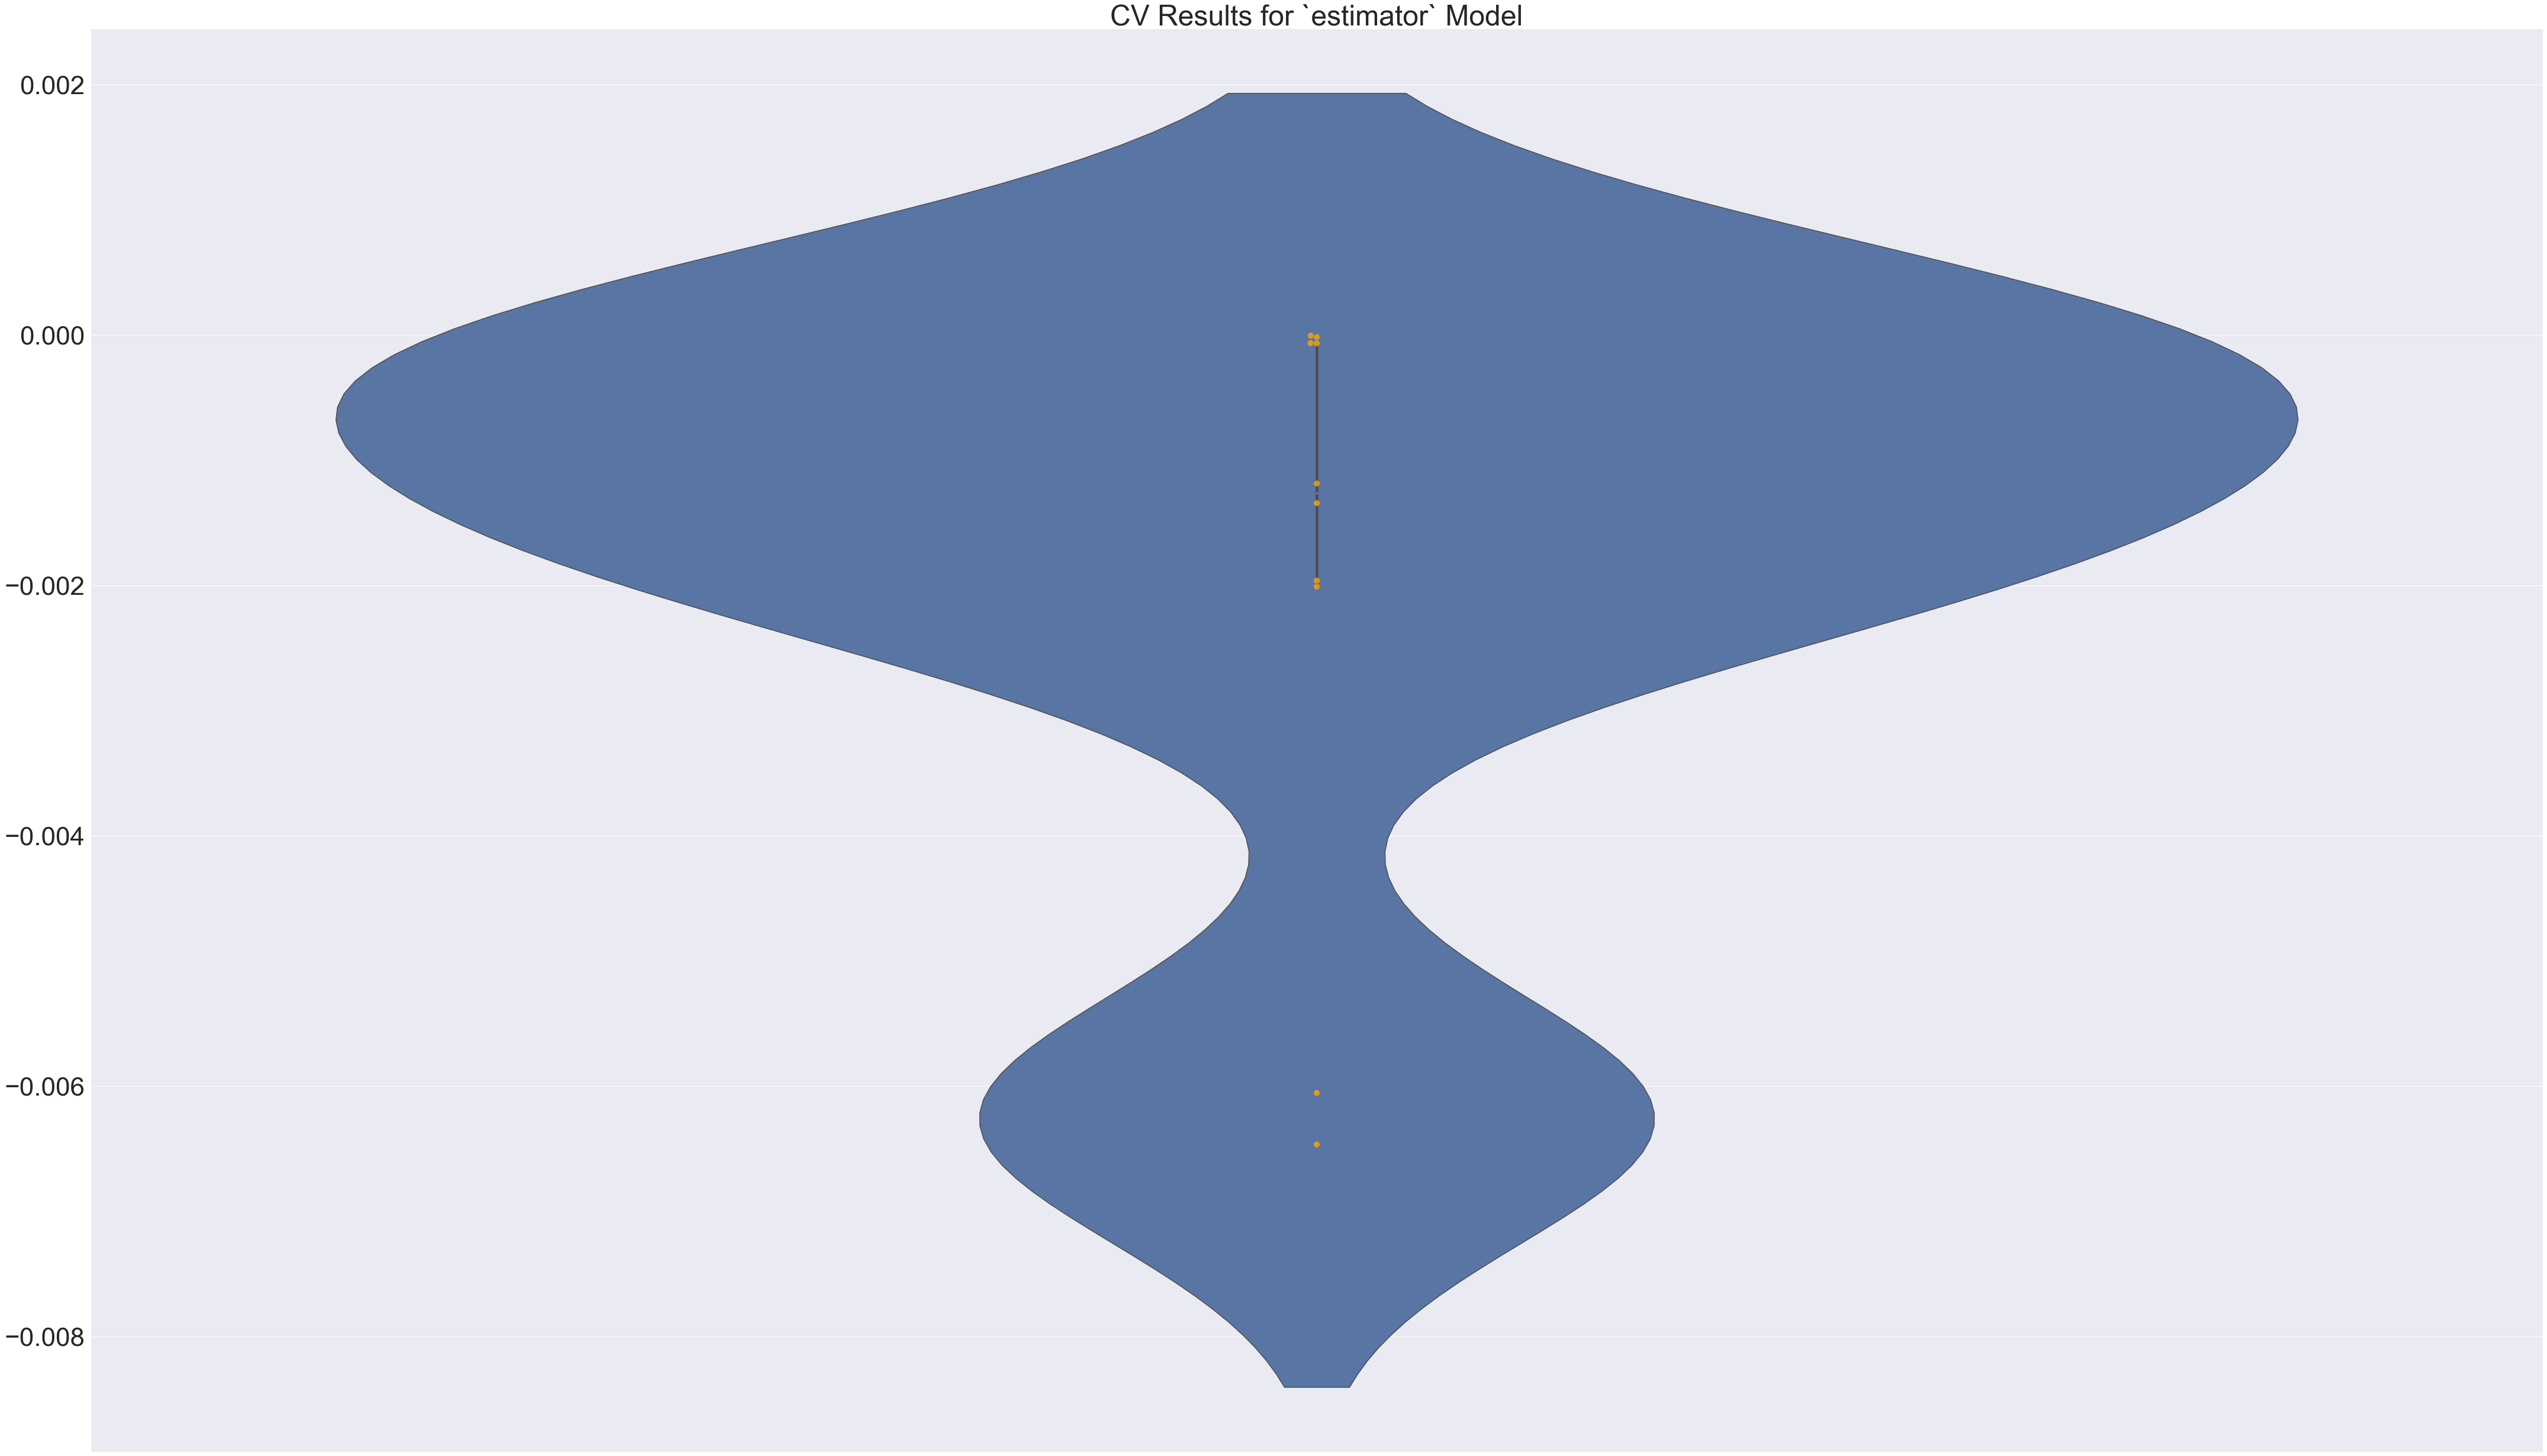

In [45]:
f, ax = plt.subplots()

cv.plot_cv(ax);

In [46]:
cv.print_cv_summary()

CV Results for `estimator` model:
            -0.00192 ± 0.00230 accuracy
        


## Logistic Regression

In [66]:
pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=4)),
    ('estimator', LogisticRegression(random_state=42))
])

In [67]:
param_grid = {}
param_grid['estimator__C'] = [100, 10, 1.0, 0.1, 0.01]
param_grid['estimator__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
param_grid['estimator__penalty'] = ['l2']
# param_grid['estimator__class_weight'] = ['balanced', None]
# param_grid['estimator__n_jobs'] = [-1]
# param_grid['estimator__l1_ratio'] = [0, 1]

In [68]:
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           verbose=1)

In [69]:
grid_search.fit(X_train, y_train)

Fitting 30 folds for each of 15 candidates, totalling 450 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=4)),
                                       ('estimator',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1, 0.01],
                         'estimator__penalty': ['l2'],
                         'estimator__solver': ['newton-cg', 'lbfgs',
                                               'liblinear']},
             return_train_score=True, scoring='accuracy', verbose=1)

In [70]:
# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

print(classification_report(y_test, y_pred))

Mean Training Score: 63.43%

Mean Test Score: 67.39%

Accuracy Score: 67.39%

Optimal Parameters: {'estimator__C': 0.01, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}

Testing Accuracy: 63.47%

              precision    recall  f1-score   support

           0       0.62      0.54      0.58       571
           1       0.70      0.77      0.74       812

    accuracy                           0.67      1383
   macro avg       0.66      0.65      0.66      1383
weighted avg       0.67      0.67      0.67      1383



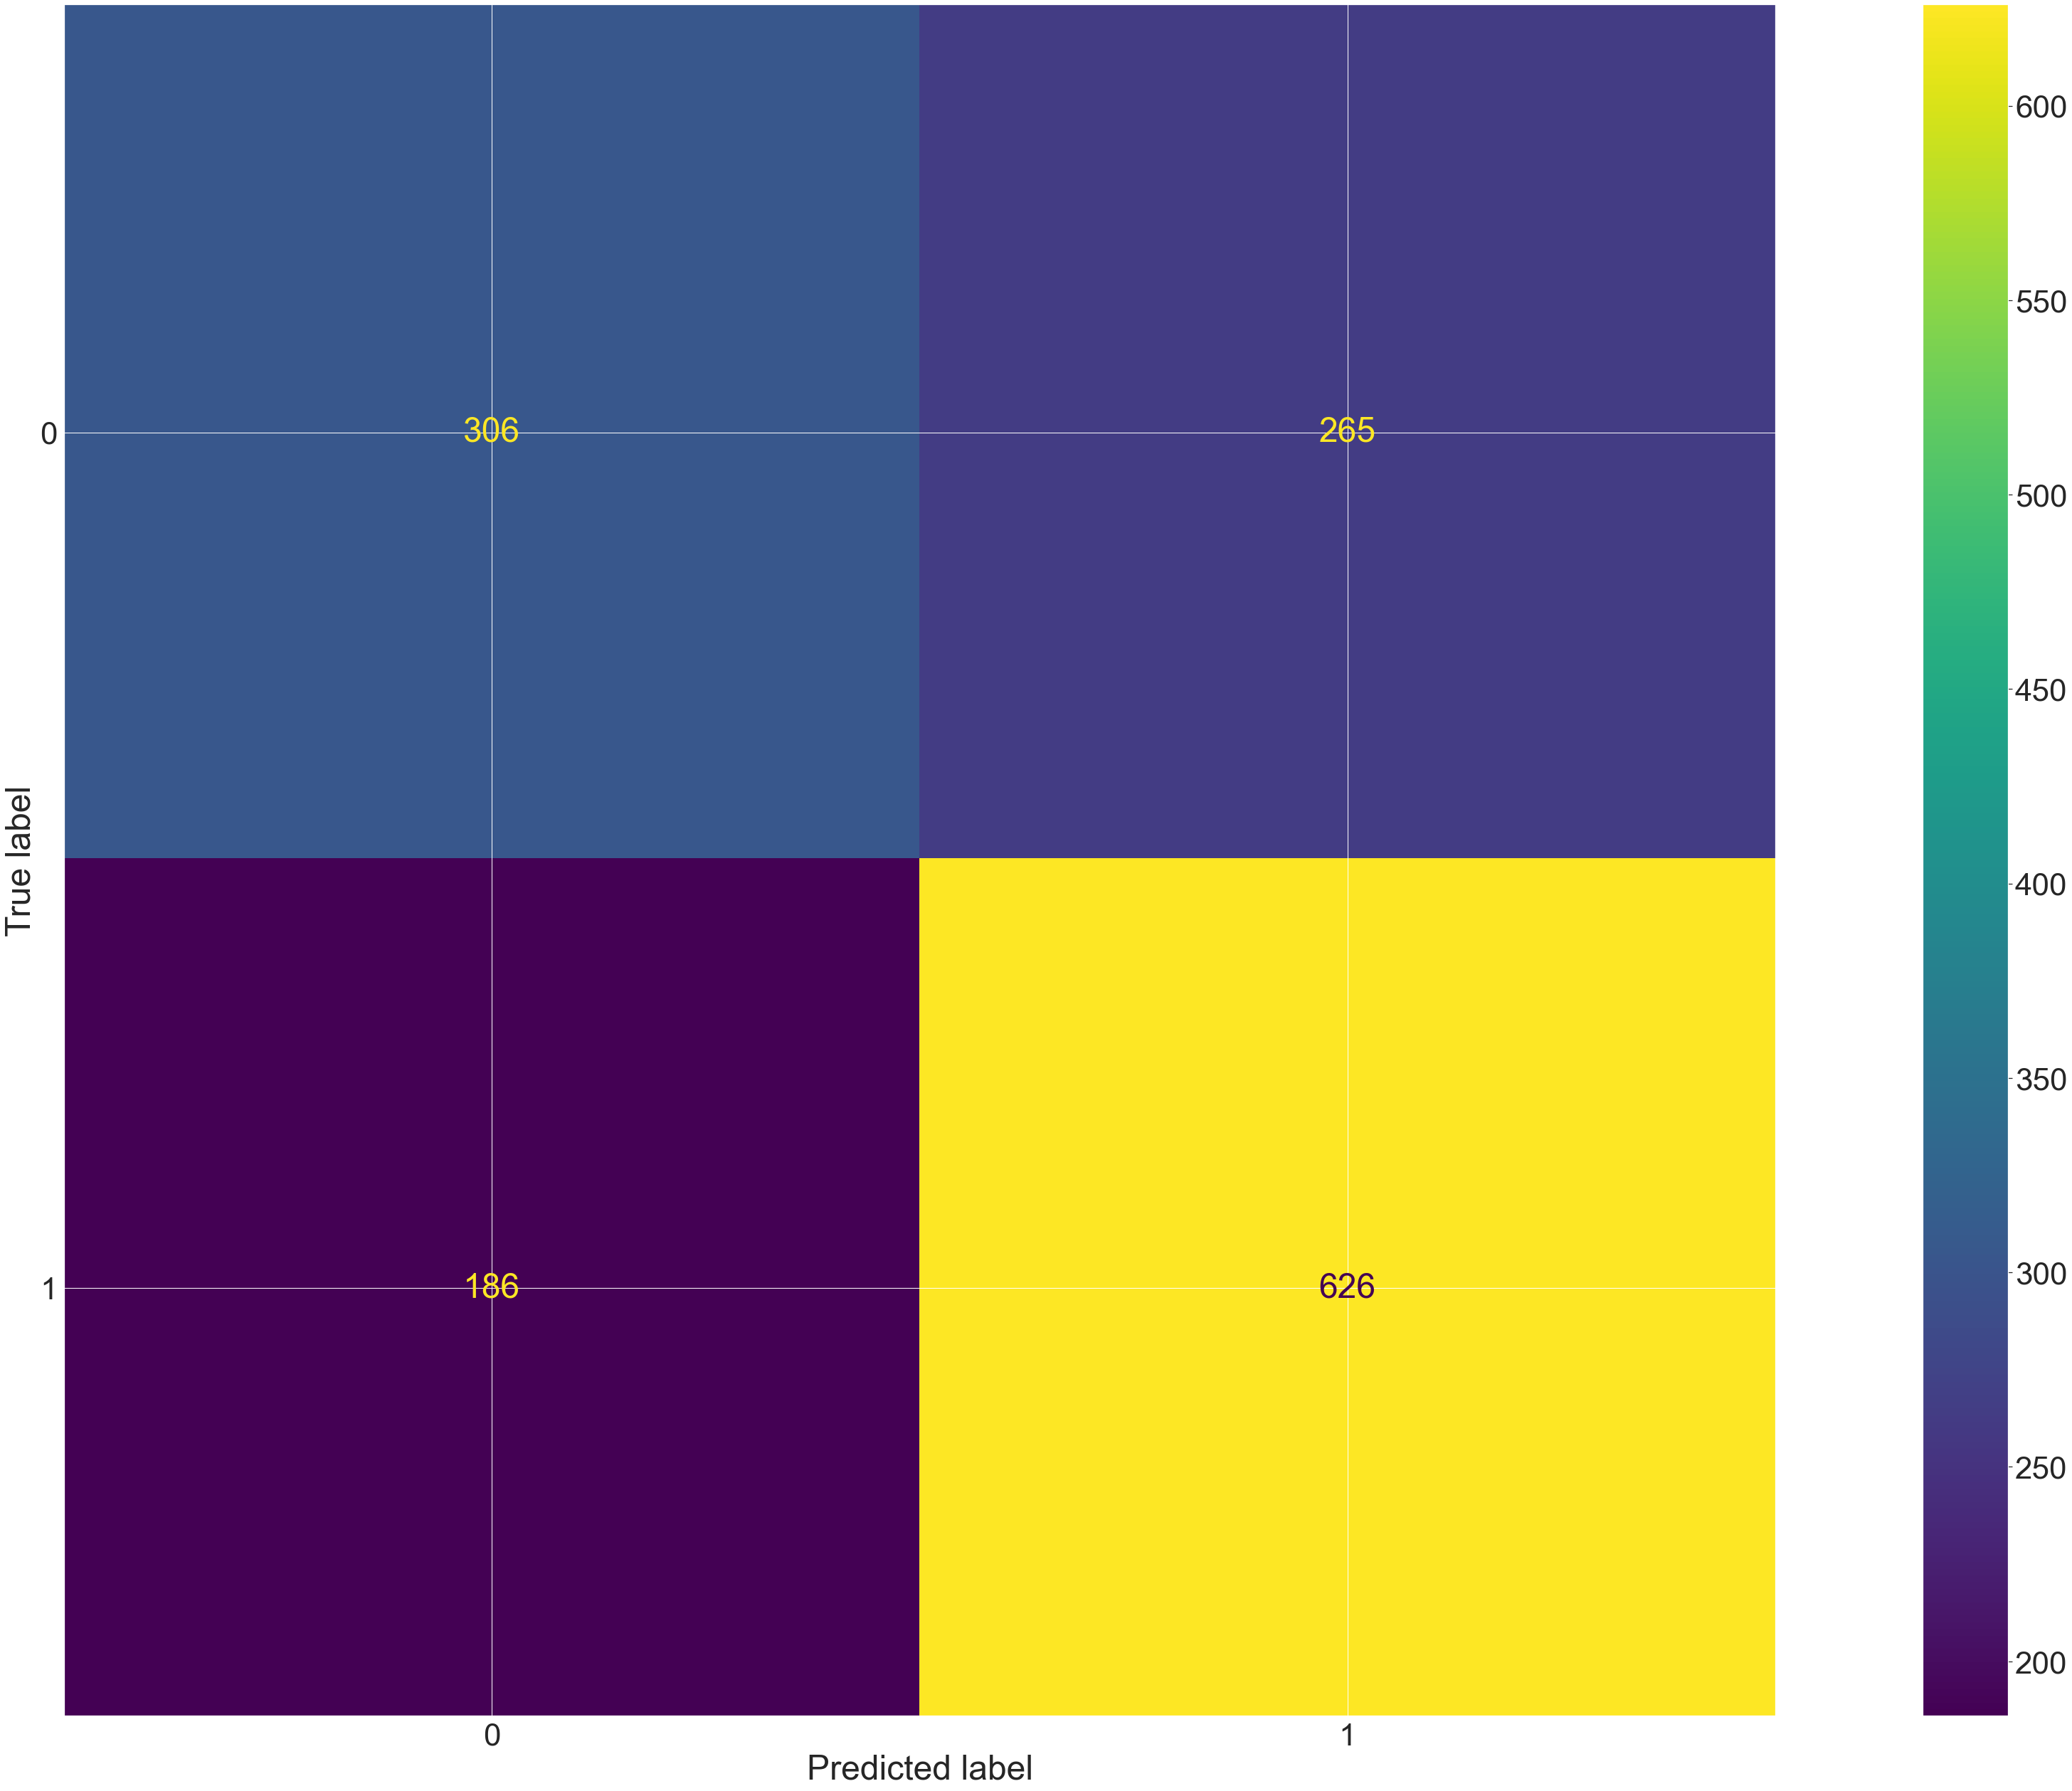

In [71]:
# Plot a confusion matrix on the test data
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test);

## Ridge

In [16]:
pipe = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=4)),
    ('estimator', RidgeClassifier())
])


param_grid = {}
param_grid['estimator__alpha'] = np.linspace(0, 200, num=50)
# param_grid['estimator__solver'] = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
# param_grid['estimator__subsample'] = [0.5, 0.7, 1.0]
# param_grid['estimator__max_depth'] = [3, 7, 9]


grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)


grid_search.fit(X_train, y_train)


# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

print(classification_report(y_test, y_pred))

Fitting 30 folds for each of 50 candidates, totalling 1500 fits
Mean Training Score: 63.42%

Mean Test Score: 67.32%

Accuracy Score: 67.32%

Optimal Parameters: {'estimator__alpha': 0.0}

Testing Accuracy: 63.37%

              precision    recall  f1-score   support

           0       0.63      0.52      0.57       571
           1       0.70      0.78      0.74       812

    accuracy                           0.67      1383
   macro avg       0.66      0.65      0.65      1383
weighted avg       0.67      0.67      0.67      1383



## Random Forest - Random Search CV

In [ ]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', RandomForestClassifier(random_state=42))
])

In [ ]:
param_grid = {}
param_grid['estimator__n_estimators'] = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
param_grid['estimator__max_features'] = ['auto', 'sqrt', 'log2']
param_grid['estimator__max_depth'] = [int(x) for x in np.linspace(10, 110, num=11)]
param_grid['estimator__min_samples_split'] = [2, 5, 10]
param_grid['estimator__min_samples_leaf'] = [1, 2, 4]



In [ ]:
grid_search = RandomizedSearchCV(estimator=pipe, 
                                 param_distributions=param_grid, 
                                 cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                                 return_train_score=True, 
                                 scoring='accuracy', 
                                 n_iter=100, 
                                 random_state=42, 
                                 n_jobs=-1, 
                                 verbose=2)


In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

print(classification_report(y_test, y_pred))

## Random Forest - Grid Search CV

In [32]:
pipe = Pipeline(steps=[
    ('estimator', RandomForestClassifier(random_state=42))
])

In [33]:
param_grid = {}
param_grid['estimator__n_estimators'] = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
param_grid['estimator__max_features'] = ['auto', 'sqrt']
param_grid['estimator__max_depth'] = [int(x) for x in np.linspace(10, 110, num=11)]
param_grid['estimator__min_samples_split'] = [2, 5, 10]
param_grid['estimator__min_samples_leaf'] = [1, 2, 4]
# param_grid['estimator__bootstrap'] = [True, False]


In [34]:
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=1)


In [35]:
grid_search.fit(X_train, y_train)

Fitting 30 folds for each of 1980 candidates, totalling 59400 fits


KeyboardInterrupt: 

In [ ]:
# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

print(classification_report(y_test, y_pred))

In [ ]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', RandomForestClassifier(random_state=42))
])


param_grid = {}
param_grid['estimator__n_estimators'] = [10, 100, 1000]
param_grid['estimator__max_features'] = ['sqrt', 'log2']
# param_grid['estimator__max_depth'] = [int(x) for x in np.linspace(10, 110, num=11)]
# param_grid['estimator__min_samples_split'] = [2, 5, 10]
# param_grid['estimator__min_samples_leaf'] = [1, 2, 4]
# param_grid['estimator__bootstrap'] = [True, False]

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)


grid_search.fit(X_train, y_train)


# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

print(classification_report(y_test, y_pred))

In [18]:
model = RandomForestClassifier(random_state=42,
                              n_jobs=-1,
                              n_estimators=600,
                              min_samples_split=5,
                              min_samples_leaf=4,
                              max_features='auto',
                              max_depth=30,
                              bootstrap=False)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=30, max_features='auto',
                       min_samples_leaf=4, min_samples_split=5,
                       n_estimators=600, n_jobs=-1, random_state=42)

In [17]:
# (pd.Series(model.feature_importances_, index=X.columns)
#    .nlargest(10)
#    .plot(kind='barh'));

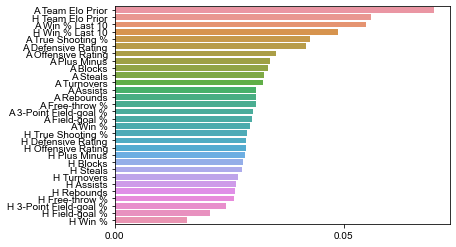

In [19]:
# figure size in inches
# plt.ylabel('Features', fontsize=34)


sns.barplot(x=pd.Series(model.feature_importances_).sort_values(ascending=False), 
            y=X.columns).set_yticklabels(['A Team Elo Prior',
                                          'H Team Elo Prior',
                                          'A Win % Last 10',
                                          'H Win % Last 10',
                                          'A True Shooting %',
                                          'A Defensive Rating',
                                          'A Offensive Rating',
                                          'A Plus Minus',
                                          'A Blocks',
                                          'A Steals',
                                          'A Turnovers',
                                          'A Assists',
                                          'A Rebounds',
                                          'A Free-throw %',
                                          'A 3-Point Field-goal %',
                                          'A Field-goal %',
                                          'A Win %',
                                          'H True Shooting %',
                                          'H Defensive Rating',
                                          'H Offensive Rating',
                                          'H Plus Minus',
                                          'H Blocks',
                                          'H Steals',
                                          'H Turnovers',
                                          'H Assists',
                                          'H Rebounds',
                                          'H Free-throw %',
                                          'H 3-Point Field-goal %',
                                          'H Field-goal %',
                                          'H Win %'])





sns.set(rc={'figure.figsize':(74.24, 44.24)})
sns.set(font_scale=4);
# plt.title('Feature Importance');


## Gaussian Naive Bayes

In [ ]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', GaussianNB())
])

In [ ]:
param_grid = {}
param_grid['estimator__var_smoothing'] = np.logspace(0,-11, num=100)
#param_grid['estimator__var_smoothing'] = [1e-11, 1e-10, 1e-9]


In [ ]:
grid_search = RandomizedSearchCV(estimator=pipe, 
                                 param_distributions=param_grid, 
                                 cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                                 return_train_score=True, 
                                 scoring='accuracy', 
                                 random_state=42,
                                 n_jobs = -1,
                                 verbose=2)


In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

print(classification_report(y_test, y_pred))

In [20]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', GaussianNB())
])

In [21]:
param_grid = {}
param_grid['estimator__var_smoothing'] = np.logspace(0,-9, num=100)


In [22]:
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)


In [23]:
grid_search.fit(X_train, y_train)

Fitting 30 folds for each of 100 candidates, totalling 3000 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estimator', GaussianNB())]),
             n_jobs=-1,
             param_grid={'estimator__var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742...
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             return_train_score=True, scoring='accuracy', verbose=2)

In [24]:
# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

print(classification_report(y_test, y_pred))

Mean Training Score: 63.25%

Mean Test Score: 65.65%

Accuracy Score: 65.65%

Optimal Parameters: {'estimator__var_smoothing': 0.2848035868435802}

Testing Accuracy: 63.18%

              precision    recall  f1-score   support

           0       0.58      0.61      0.60       571
           1       0.72      0.69      0.70       812

    accuracy                           0.66      1383
   macro avg       0.65      0.65      0.65      1383
weighted avg       0.66      0.66      0.66      1383



## K Nearest Neighbors

In [25]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', KNeighborsClassifier())
])

In [26]:
param_grid = {}
param_grid['estimator__n_neighbors'] = range(1, 21, 2)
param_grid['estimator__p'] = [1, 2]
param_grid['estimator__weights'] = ['uniform', 'distance']
param_grid['estimator__metric'] = ['euclidean', 'manhattan', 'minkowski']
# param_grid['estimator__leaf_size'] = (20, 40, 1)



In [27]:
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy',
                           n_jobs = -1,
                           verbose=2)

In [28]:
grid_search.fit(X_train, y_train)

Fitting 30 folds for each of 120 candidates, totalling 3600 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=42),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('estimator', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'estimator__metric': ['euclidean', 'manhattan',
                                               'minkowski'],
                         'estimator__n_neighbors': range(1, 21, 2),
                         'estimator__p': [1, 2],
                         'estimator__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy', verbose=2)

In [29]:
# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

print(classification_report(y_test, y_pred))

Mean Training Score: 86.82%

Mean Test Score: 65.29%

Accuracy Score: 65.29%

Optimal Parameters: {'estimator__metric': 'euclidean', 'estimator__n_neighbors': 19, 'estimator__p': 1, 'estimator__weights': 'uniform'}

Testing Accuracy: 63.39%

              precision    recall  f1-score   support

           0       0.59      0.52      0.55       571
           1       0.69      0.74      0.72       812

    accuracy                           0.65      1383
   macro avg       0.64      0.63      0.64      1383
weighted avg       0.65      0.65      0.65      1383



## Gradient Boosting

In [30]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', GradientBoostingClassifier(random_state=42))
])


param_grid = {}
param_grid['estimator__n_estimators'] = [10, 100, 1000]
param_grid['estimator__learning_rate'] = [0.001, 0.01, 0.1]
param_grid['estimator__subsample'] = [0.5, 0.7, 1.0]
param_grid['estimator__max_depth'] = [3, 7, 9]


grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy',
                           n_jobs=-1,
                           verbose=2)


grid_search.fit(X_train, y_train)


# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

print(classification_report(y_test, y_pred))

Fitting 30 folds for each of 81 candidates, totalling 2430 fits
Mean Training Score: 75.86%

Mean Test Score: 65.51%

Accuracy Score: 65.51%

Optimal Parameters: {'estimator__learning_rate': 0.01, 'estimator__max_depth': 3, 'estimator__n_estimators': 1000, 'estimator__subsample': 0.7}

Testing Accuracy: 63.65%

              precision    recall  f1-score   support

           0       0.59      0.52      0.55       571
           1       0.69      0.75      0.72       812

    accuracy                           0.66      1383
   macro avg       0.64      0.64      0.64      1383
weighted avg       0.65      0.66      0.65      1383



## Support Vector Machine

In [31]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('estimator', SVC(random_state=42))
])

kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']


param_grid = {}
param_grid['estimator__kernel'] = ['poly', 'rbf', 'sigmoid']
param_grid['estimator__C'] = [50, 10, 1.0, 0.1, 0.01]
param_grid['estimator__gamma'] = ['scale']

grid_search = RandomizedSearchCV(estimator=pipe, 
                                 param_distributions=param_grid, 
                                 cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                                 return_train_score=True, 
                                 scoring='accuracy', 
                                 n_iter=100, 
                                 random_state=42, 
                                 n_jobs=-1, 
                                 verbose=2)

grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42), 
                           return_train_score=True, 
                           scoring='accuracy',
                           n_jobs = -1,
                           verbose=2)


grid_search.fit(X_train, y_train)


# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

print(classification_report(y_test, y_pred))

Fitting 30 folds for each of 15 candidates, totalling 450 fits
Mean Training Score: 68.74%

Mean Test Score: 66.52%

Accuracy Score: 66.52%

Optimal Parameters: {'estimator__C': 0.1, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}

Testing Accuracy: 63.97%

              precision    recall  f1-score   support

           0       0.64      0.42      0.51       571
           1       0.67      0.84      0.75       812

    accuracy                           0.67      1383
   macro avg       0.66      0.63      0.63      1383
weighted avg       0.66      0.67      0.65      1383



## XGB

In [ ]:
pipe = Pipeline(steps=[
    ('estimator', xgboost.XGBRegressor(random_state=42, objective='reg:squarederror'))
])



In [ ]:
param_grid = {}
param_grid['estimator__min_child_weight'] = [1, 5, 10],
param_grid['estimator__gamma'] = [0.5, 1, 1.5, 2, 5],
param_grid['estimator__subsample'] = [0.6, 0.8, 1.0],
param_grid['estimator__colsample_bytree'] = [0.6, 0.8, 1.0],
param_grid['estimator__max_depth'] = [3, 4, 5]

In [ ]:
grid_search = GridSearchCV(estimator=pipe, 
                           param_grid=param_grid, 
                           cv=10, 
                           return_train_score=True, 
                           scoring='accuracy',
                           n_jobs = -1,
                           verbose=1)


In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
# Mean training score
grid_train_score = np.mean(grid_search.cv_results_['mean_train_score'])

# Mean test score
grid_test_score = grid_search.score(X_test, y_test)

best_grid = grid_search.best_estimator_
best_grid.fit(X_train, y_train)
y_pred = best_grid.predict(X_test)

print(f"Mean Training Score: {grid_train_score:.2%}\n")
print(f"Mean Test Score: {grid_test_score:.2%}\n")

print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}\n")
print(f"Optimal Parameters: {grid_search.best_params_}\n")
print(f"Testing Accuracy: {grid_search.best_score_:.2%}\n")

print(classification_report(y_test, y_pred))

In [ ]:
# Plot a confusion matrix on the test data
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(final_model, X_test, y_test);

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd


#script to test the effectivenes of each model, uses default parameters
#test six different classification models 
def run_exps(X_train, y_train, X_test, y_test) :
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier())
        ]
    
    results = []
    
    names = []
    
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    
    target_names = ['win', 'loss']
    
    for name, model in models:
        
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        
        results.append(cv_results)
        names.append(name)
        
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
    final = pd.concat(dfs, ignore_index=True)
    
    return final
final = run_exps(X_train, y_train, X_test, y_test)
final

# Model Performance

In [ ]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

In [ ]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./benchmark_models_time.png',dpi=300)

In [ ]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

# Final Selected Model
- grid search for parameters 
- Gaussian NB

In [ ]:
# Gaussian NB only has one parameter 'var_smoothing'
# Portion of the largest variance of all features that is added to variances for calculation stability.
# Number of different combinations of parameters 

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

nb_classifier = GaussianNB()

target_names = ['Win', 'Loss']

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)

gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB, 
                 cv=kfold,   
                 verbose=1, 
                 scoring='accuracy', n_jobs=-1) 

gs_NB.fit(X_train, y_train)

best_gs_grid = gs_NB.best_estimator_
best_gs_grid.fit(X_train, y_train)
y_pred_best_gs = best_gs_grid.predict(X_test)

print(classification_report(y_test, y_pred_best_gs, target_names=target_names))
gs_NB.best_params_

In [ ]:
from sklearn.metrics import confusion_matrix
confusionMatrix = confusion_matrix(y_test, y_pred_best_gs)
print(confusionMatrix)

# Confusion Matrix

In [ ]:
confusionMatrix = confusion_matrix(y_test, y_pred_best_gs)  

    # Code below prints model accuracy information
print('Coefficient Information:')

for i in range(len(featureColumns)):  

    logregCoefficients = logreg.coef_

    currentFeature = featureColumns[i]
    currentCoefficient = logregCoefficients[0][i]

    print(currentFeature + ': ' + str(currentCoefficient))

print('----------------------------------')

print("Accuracy:", metrics.accuracy_score(Y_test, Y_pred))
print("Precision:", metrics.precision_score(Y_test, Y_pred))
print("Recall:", metrics.recall_score(Y_test, Y_pred))

print('----------------------------------')

print('Confusion Matrix:')
print(confusionMatrix)

# Saving Model

In [ ]:
import pickle

# Saves the model in folder to be used in future
# filename should be end in '.pkl'
def save_model(model, filename):

    with open(filename, 'wb') as file:
        pickle.dump(model, file)
save_model()